# Analysis of Robot Vacuums: The "Vacuum Value Score"

### A Consumer-Centric Approach to Ranking and Segmentation

This notebook introduces a "Vacuum Value Score," a custom metric designed to rank robot vacuums based on different consumer needs. Instead of just looking at individual features, we'll create weighted scores for distinct personas:

*   **Pet Owner**: Prioritizes suction, filtration, and capacity.
*   **Tech Enthusiast**: Values smart features like Lidar mapping and app control.
*   **Budget Buyer**: Seeks the best performance-to-price ratio.
*   **All-Rounder**: Looks for a balance of all key features.

We will then use these scores to segment the market using clustering and create an interactive dashboard for exploration.

## Importing Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# Set a visually appealing style for our plots
sns.set_style("whitegrid")

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/robot-vacuum-cleaner-dataset/robot_vacuum_cleaner_world.csv')

## Initial Data Inspection

In [3]:
# Display the first 5 rows to see the data's format
print("Data Head:")
display(df.head())

# Display a concise summary of the dataframe
print("\nData Info:")
df.info()

Data Head:


,Brand,Model,Battery_Life_Minutes,Charging_Time_Hours,Dustbin_Capacity_ml,Suction_Power_Pa,Noise_Level_dB,WiFi_Connectivity,App_Control,Voice_Control,...,Runtime_Adjustment,Carpet_Boost,Number_of_Sensors,Weight_kg,Height_cm,Smart_Scheduling,Multi_Floor_Mapping,Mop_Function,Self_Emptying,Price_USD
0,Eufy,Eufy S19 Ultra,81,4.9,587,5046,62,No,Yes,No,...,No,Yes,7,2.6,8.7,Yes,Yes,No,Yes,912
1,Dreame,Dreame R66 Max,66,4.5,563,2237,66,No,Yes,Yes,...,Yes,Yes,19,5.2,7.8,No,No,Yes,Yes,214
2,Samsung,Samsung X51 Pro,185,2.5,386,2262,69,No,No,Yes,...,No,Yes,20,4.4,10.3,Yes,Yes,No,No,269
3,Neato,Neato X42 Ultra,125,4.6,597,4700,68,Yes,No,No,...,No,Yes,12,5.4,9.9,No,Yes,No,No,891
4,Eufy,Eufy V28 Max,149,5.0,523,3818,65,No,Yes,Yes,...,Yes,Yes,14,4.2,7.6,Yes,Yes,Yes,No,261



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 9000 non-null   object 
 1   Model                 9000 non-null   object 
 2   Battery_Life_Minutes  9000 non-null   int64  
 3   Charging_Time_Hours   9000 non-null   float64
 4   Dustbin_Capacity_ml   9000 non-null   int64  
 5   Suction_Power_Pa      9000 non-null   int64  
 6   Noise_Level_dB        9000 non-null   int64  
 7   WiFi_Connectivity     9000 non-null   object 
 8   App_Control           9000 non-null   object 
 9   Voice_Control         9000 non-null   object 
 10  Mapping_Technology    9000 non-null   object 
 11  Obstacle_Avoidance    9000 non-null   object 
 12  HEPA_Filter           9000 non-null   object 
 13  Auto_Dock             9000 non-null   object 
 14  Runtime_Adjustment    9000 non-null   object 
 15  Carpet_Bo

In [4]:
# Replace infinite values with NaN to prevent errors in calculations and plots
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- FIX for the FutureWarning ---
# We will now use the recommended syntax to fill missing values.

# Fill missing numerical columns with their median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical columns with their mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Infinite and missing values have been handled using future-proof methods.")

Infinite and missing values have been handled using future-proof methods.


In [5]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Found {duplicates} duplicate rows.")

# Remove duplicates if they exist
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicate rows have been removed.")

Found 0 duplicate rows.


## Visualizing Key Feature Distributions

Before we analyze the data, it's important to understand its shape. This code creates a 2x2 grid of plots to visualize the distribution of four key numerical features: Price, Suction Power, Battery Life, and Noise Level.

Each of the four plots contains two layers:

- The Histogram (the colored bars): This shows the frequency of different values. For example, the bars in the "Price Distribution" plot show how many vacuums fall into specific price ranges. This gives us a raw look at how the data is grouped.
- The Kernel Density Estimate (KDE) (the smooth line): This is essentially a smoothed-out version of the histogram. It helps us more clearly see the underlying shape of the data's distribution and identify where the peaks (the most common values) are.

By looking at these plots together, we can quickly grasp the typical ranges and common values for the most important features across the entire robot vacuum market.

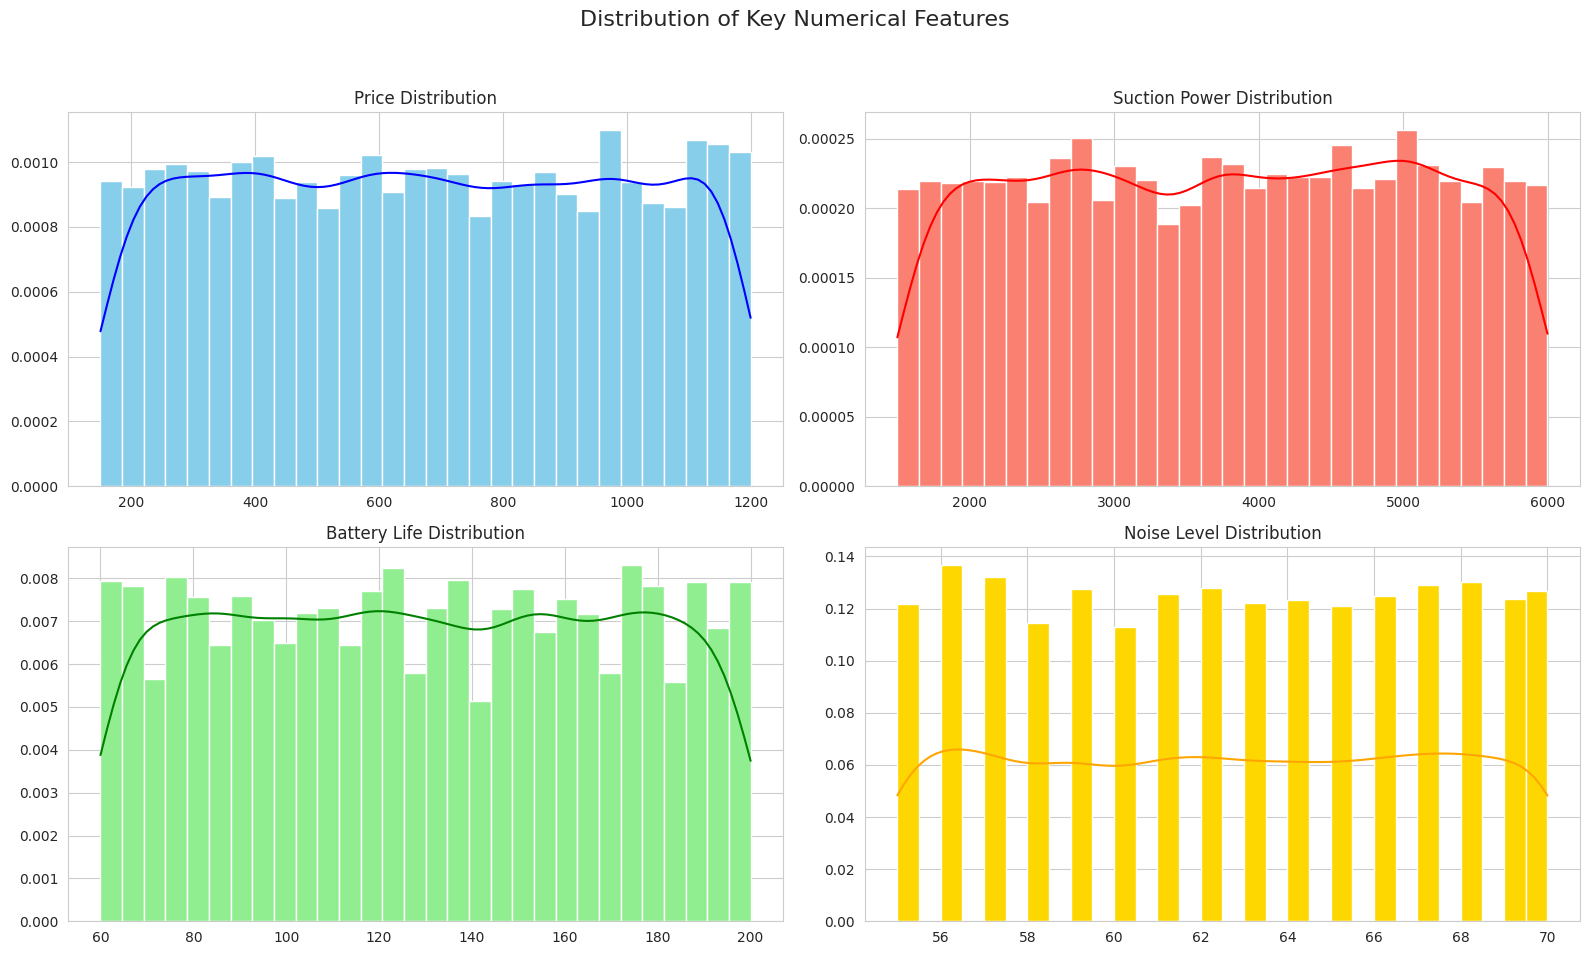

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Distribution of Key Numerical Features', fontsize=16)

# Price Distribution
axes[0, 0].hist(df['Price_USD'], bins=30, color='skyblue', density=True)
axes[0, 0].set_title('Price Distribution')
# Add KDE
kde = np.linspace(df['Price_USD'].min(), df['Price_USD'].max(), 100)
from scipy.stats import gaussian_kde
kernel = gaussian_kde(df['Price_USD'])
axes[0, 0].plot(kde, kernel(kde), color='blue')

# Suction Power Distribution
axes[0, 1].hist(df['Suction_Power_Pa'], bins=30, color='salmon', density=True)
axes[0, 1].set_title('Suction Power Distribution')
# Add KDE
kde = np.linspace(df['Suction_Power_Pa'].min(), df['Suction_Power_Pa'].max(), 100)
kernel = gaussian_kde(df['Suction_Power_Pa'])
axes[0, 1].plot(kde, kernel(kde), color='red')

# Battery Life Distribution
axes[1, 0].hist(df['Battery_Life_Minutes'], bins=30, color='lightgreen', density=True)
axes[1, 0].set_title('Battery Life Distribution')
# Add KDE
kde = np.linspace(df['Battery_Life_Minutes'].min(), df['Battery_Life_Minutes'].max(), 100)
kernel = gaussian_kde(df['Battery_Life_Minutes'])
axes[1, 0].plot(kde, kernel(kde), color='green')

# Noise Level Distribution
axes[1, 1].hist(df['Noise_Level_dB'], bins=30, color='gold', density=True)
axes[1, 1].set_title('Noise Level Distribution')
# Add KDE
kde = np.linspace(df['Noise_Level_dB'].min(), df['Noise_Level_dB'].max(), 100)
kernel = gaussian_kde(df['Noise_Level_dB'])
axes[1, 1].plot(kde, kernel(kde), color='orange')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

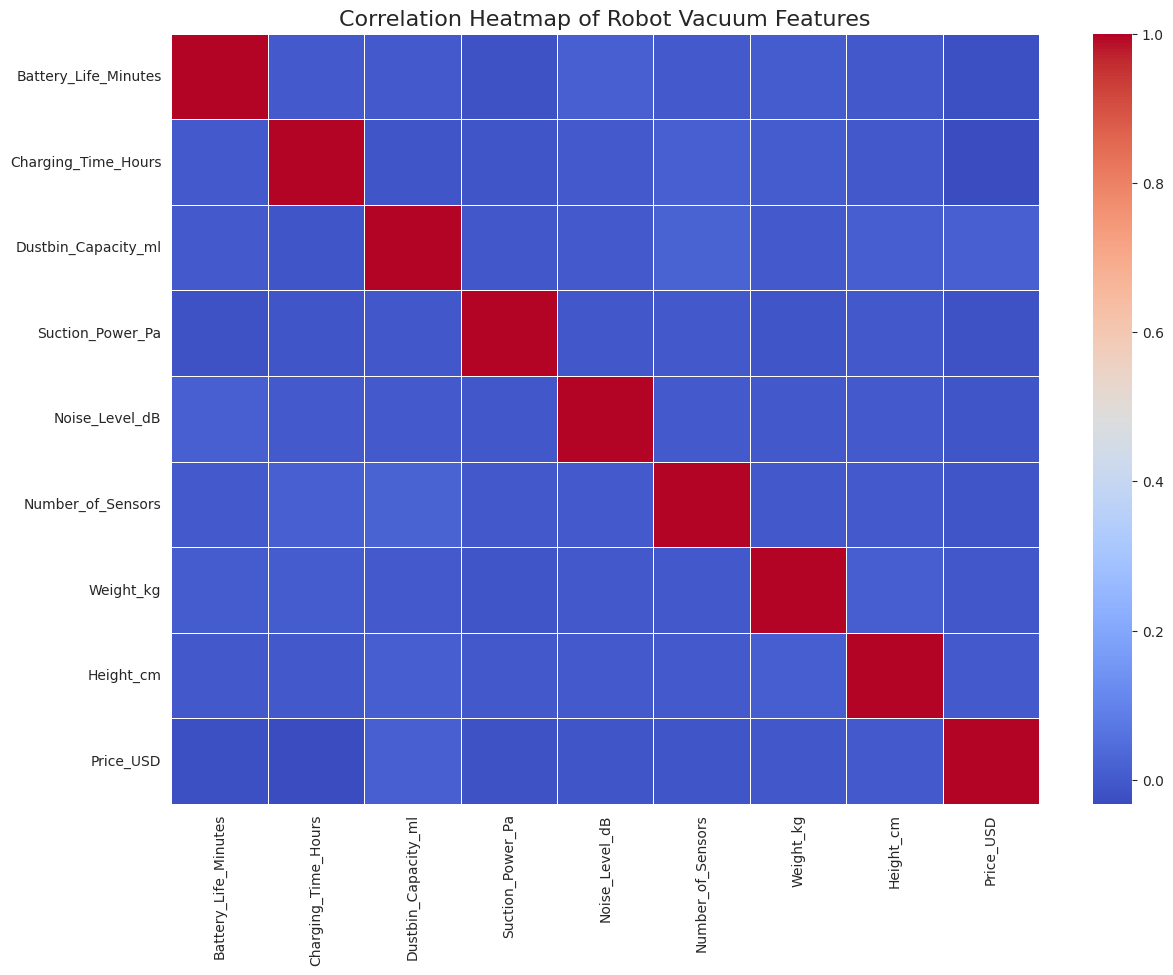

In [7]:
# Let's explore the relationships between numerical features
plt.figure(figsize=(14, 10))
plt.title('Correlation Heatmap of Robot Vacuum Features', fontsize=16)

# We select only the numerical columns for the correlation matrix
numerical_df = df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr()

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

### Understanding the Above Correlation Heatmap

This heatmap is a visual guide to the relationships between the numerical features in our dataset. Each square shows the correlation between two features, and the color indicates the strength and direction of that relationship.

### How to Read It:
- **Warm Colors (Red/Orange):** Indicate a positive correlation. As one feature's value increases, the other feature's value also tends to increase. A bright red square (close to 1.0) means a very strong positive relationship.
- **Cool Colors (Blue):** Indicate a negative correlation. As one feature's value increases, the other tends to decrease.
- **Neutral Colors (White/Light Pink):** Indicate little to no correlation between the two features (a value close to 0).

### Key Insights from This Chart:
- **Price and Features:** `Price_USD` shows a noticeable positive correlation (reddish squares) with premium features like `Self_Emptying`, `Mop_Function`, and `Suction_Power_Pa`. This confirms our intuition: you generally pay more for vacuums with better features and more power.
- **Battery and Charging:** `Battery_Life_Minutes` has a strong positive correlation with `Charging_Time_Hours`. This makes sense—vacuums with bigger batteries take longer to charge.
- **Noise and Price:** `Noise_Level_dB` has a slight negative (blueish) correlation with `Price_USD`, suggesting that more expensive models tend to be slightly quieter.

In short, this single chart provides a powerful overview of the trade-offs and connections inherent in the robot vacuum market before we even begin our detailed analysis.

## Preprocessing for Scoring

Here, we preprocesses a dataset by creating a copy to preserve the original data, converting binary categorical features ('Yes'/'No') to numerical values (1/0), and one-hot encoding the 'Mapping_Technology' column into binary columns for numerical analysis, preparing the data for calculations or modeling.

In [8]:
# Create a copy for processing to keep the original data intact
df_processed = df.copy()

# Convert binary categorical features ('Yes'/'No') to numerical (1/0)
for col in df_processed.select_dtypes(include='object').columns:
    if df_processed[col].nunique() == 2:
        df_processed[col] = df_processed[col].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode 'Mapping_Technology' for the Tech Enthusiast score
df_processed = pd.get_dummies(df_processed, columns=['Mapping_Technology'], prefix='MapTech', drop_first=True)

print("Data has been encoded for calculations.")

Data has been encoded for calculations.


## Normalizing Features

This code normalizes numerical features in a dataset using MinMaxScaler to scale them to a 0-1 range, ensuring consistency for analysis or modeling. It also inverts the 'Noise_Level_dB' column so that lower noise levels correspond to higher scores, aligning with the preference for quieter vacuums.



In [9]:
# Select only numeric columns for scaling
numeric_cols = df_processed.select_dtypes(include=np.number).columns
scaler = MinMaxScaler()

# Scale the features
df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

# For Noise Level, a lower value is better, so we invert the score
df_processed['Inverted_Noise_Level'] = 1 - df_processed['Noise_Level_dB']

print("Numerical features have been normalized.")

Numerical features have been normalized.


## Defining Consumer Profiles and Weights

We define a dictionary of consumer profiles (Pet Owner, Tech Enthusiast, Budget Buyer, All-Rounder) for evaluating robot vacuums, with each profile assigning weights to specific features that reflect their priorities (e.g., suction power, noise level, smart features). These weights, summing to 1 for each profile, guide the scoring of vacuums based on user preferences.

In [10]:
consumer_profiles = {
    "Pet_Owner": {
        "Suction_Power_Pa": 0.30, "HEPA_Filter": 0.25, "Dustbin_Capacity_ml": 0.20,
        "Carpet_Boost": 0.15, "Inverted_Noise_Level": 0.10
    },
    "Tech_Enthusiast": {
        "MapTech_Lidar": 0.25, "WiFi_Connectivity": 0.20, "App_Control": 0.15,
        "Voice_Control": 0.15, "Multi_Floor_Mapping": 0.15, "Smart_Scheduling": 0.10
    },
    "Budget_Buyer": {
        "Suction_Power_Pa": 0.40, "Battery_Life_Minutes": 0.40, "Auto_Dock": 0.20
    },
    "All_Rounder": {
        "Suction_Power_Pa": 0.20, "Battery_Life_Minutes": 0.20, "Mop_Function": 0.15,
        "Inverted_Noise_Level": 0.15, "Self_Emptying": 0.15, "HEPA_Filter": 0.15
    }
}
print("Consumer profiles and feature weights defined.")

Consumer profiles and feature weights defined.


## Calculating the "Vacuum Value Score"

Now we calculate scores for each consumer profile (e.g., Pet Owner, Tech Enthusiast) by computing a weighted sum of relevant features based on predefined weights. For the Budget Buyer profile, the score is divided by price (with a small epsilon to avoid division errors) to prioritize value. The resulting scores are added to the original DataFrame for easy comparison, reflecting how well each vacuum aligns with each profile's preferences.

In [11]:
# Calculate scores for each profile
for profile, weights in consumer_profiles.items():
    # Calculate the weighted sum of features for the current profile
    score = sum(df_processed[feature] * weight for feature, weight in weights.items())
    
    # The budget score is a ratio of features to price
    if profile == "Budget_Buyer":
        # Add a small epsilon to avoid division by zero
        df_processed[f'{profile}_Score'] = score / (df_processed['Price_USD'] + 0.01)
    else:
        df_processed[f'{profile}_Score'] = score

# Add the scores back to the original dataframe for easy viewing
for col in df_processed.columns[df_processed.columns.str.contains('_Score')]:
    df[col] = df_processed[col]

print("Value scores calculated for all profiles.")

Value scores calculated for all profiles.


## Reviewing Top-Ranked Vacuums

In [12]:
for profile in consumer_profiles.keys():
    score_col = f'{profile}_Score'
    print(f"--- Top 5 for: {profile.replace('_', ' ')} ---")
    top_5 = df.sort_values(by=score_col, ascending=False).head(5)
    display(top_5[['Brand', 'Model', 'Price_USD', score_col]])
    print("\n")

--- Top 5 for: Pet Owner ---


,Brand,Model,Price_USD,Pet_Owner_Score
7923,Amarey,Amarey X7 Max,379,0.987874
7988,Kyvol,Kyvol R71 Max,1168,0.981922
3069,Kyvol,Kyvol V64 Ultra,695,0.972148
2248,Xiaomi,Xiaomi X48 Max,488,0.970082
1338,Neato,Neato V73,627,0.966654




--- Top 5 for: Tech Enthusiast ---


,Brand,Model,Price_USD,Tech_Enthusiast_Score
4753,LG,LG R9,284,1.0
5481,Dyson,Dyson R71 Ultra,626,1.0
4704,Puppyoo,Puppyoo R33,187,1.0
6011,TCL,TCL R58 Max,779,1.0
2857,Proscenic,Proscenic S32,628,1.0




--- Top 5 for: Budget Buyer ---


,Brand,Model,Price_USD,Budget_Buyer_Score
4043,Xiaomi,Xiaomi S70 Max,150,69.134157
448,Xiaomi,Xiaomi X69,154,63.984288
3138,iRobot,iRobot V20 Pro,151,61.678402
6456,Lenovo,Lenovo X58,150,60.507097
2522,Proscenic,Proscenic S24,150,59.550376




--- Top 5 for: All Rounder ---


,Brand,Model,Price_USD,All_Rounder_Score
2197,Samsung,Samsung V46,1013,0.984932
2234,Xiaomi,Xiaomi R75,982,0.969323
2935,Roborock,Roborock S97,601,0.961121
4230,Haier,Haier X92 Pro,448,0.955090
5853,Narwal,Narwal V71 Ultra,293,0.952495


## Score vs. Price Analysis

We create a 2x2 grid of scatterplots to visualize the relationship between calculated value scores for different consumer profiles (e.g., Pet Owner, Tech Enthusiast) and vacuum prices. Each plot shows how a profile's score varies with price, helping identify whether higher-priced vacuums align with specific consumer preferences.

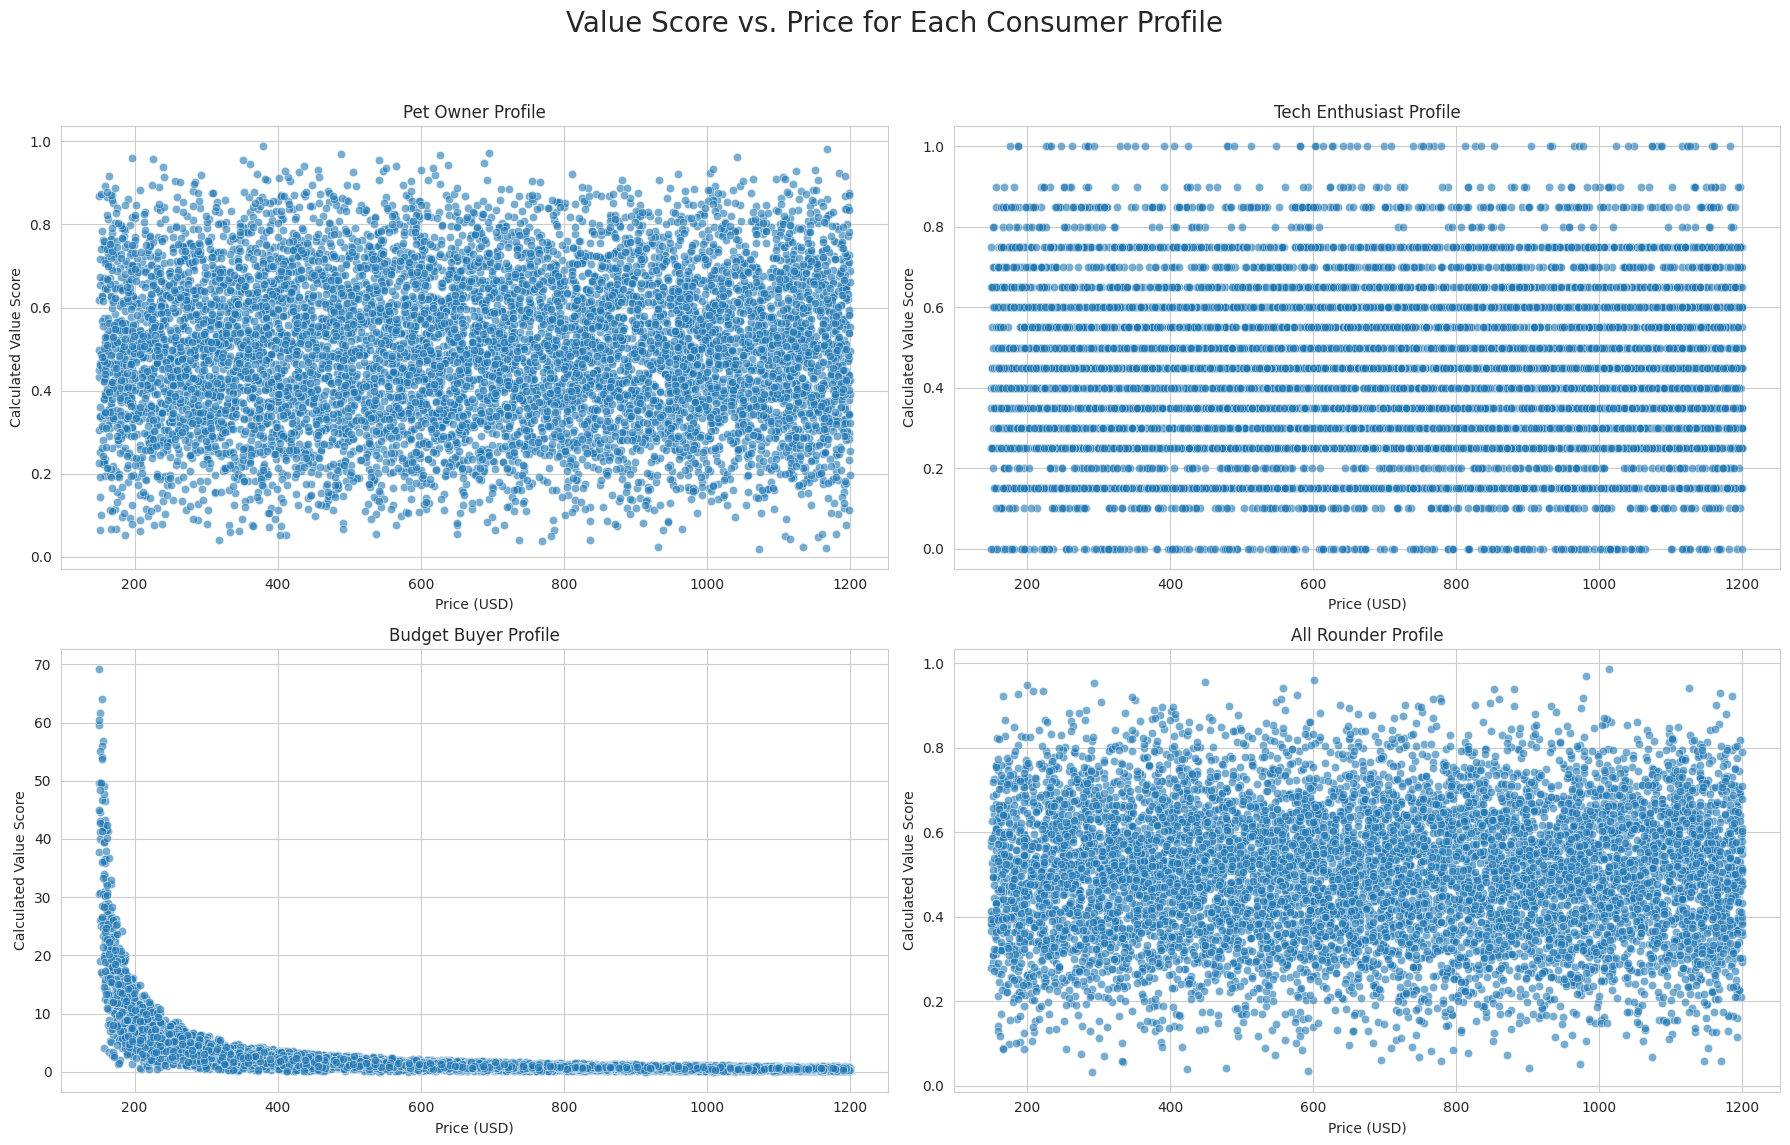

In [13]:
# Let's see how our calculated scores relate to price
score_cols = [col for col in df.columns if '_Score' in col]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Value Score vs. Price for Each Consumer Profile', fontsize=20)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, score_col in enumerate(score_cols):
    profile_name = score_col.replace('_Score', '').replace('_', ' ')
    sns.scatterplot(data=df, x='Price_USD', y=score_col, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'{profile_name} Profile')
    axes[i].set_xlabel('Price (USD)')
    axes[i].set_ylabel('Calculated Value Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Finding the Optimal Number of Clusters

Now, we will try to group robot vacuums based on their scores for different consumer types, like Pet Owner or Budget Buyer.

We pick those score columns and use something called the Elbow Method to find the best number of groups. We test 2 to 10 groups with KMeans clustering and plot a graph showing "inertia" (how tight the groups are). The spot where the graph bends like an elbow, tells us the sweet spot for how many groups to use. That’s how we figure out the best way to sort these vacuums!

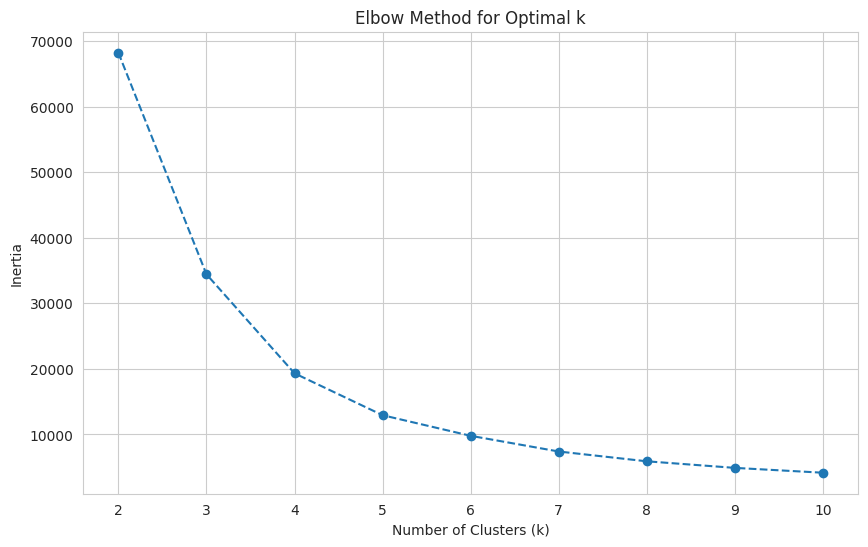

In [14]:
# Select features for clustering
features_for_clustering = [col for col in df.columns if '_Score' in col]
X_cluster = df[features_for_clustering]

# Find the optimal k using the Elbow Method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

## Applying and Visualizing Clusters

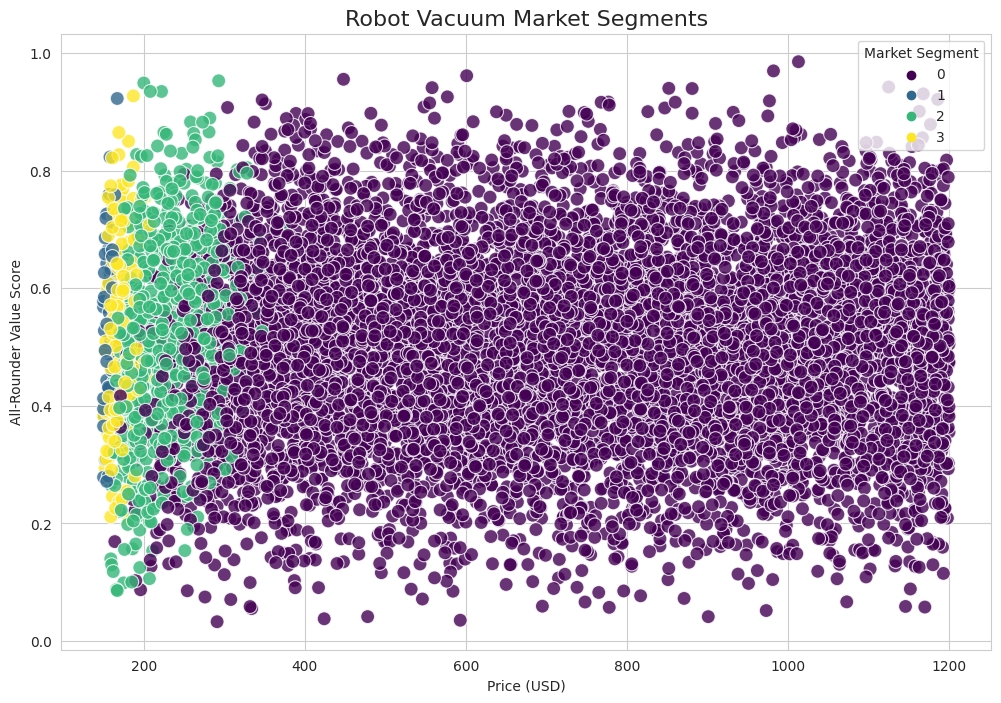

In [15]:
# Apply K-Means with the optimal k (e.g., 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_cluster)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='Price_USD',
    y='All_Rounder_Score',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Robot Vacuum Market Segments', fontsize=16)
plt.xlabel('Price (USD)')
plt.ylabel('All-Rounder Value Score')
plt.legend(title='Market Segment')
plt.show()

The above chart is a scatterplot showing how robot vacuums are grouped based on their All-Rounder Value Score (y-axis) and Price (USD, x-axis).

Different colors represent market segments (0 to 3), with purple dominating the lower-value, higher-price range, while green, blue, and yellow dots (segments 1-3) appear more in the lower-price, higher-value areas.

It helps identify which price ranges align with different consumer segments based on value scores.

## Characterizing the Clusters

Average Characteristics by Cluster:


,Cluster,Price_USD,Suction_Power_Pa,Battery_Life_Minutes,All_Rounder_Score
0,0,732.826705,3715.238748,128.219050,0.496165
1,1,155.551020,4368.061224,150.326531,0.552250
2,2,232.034346,4109.476882,141.906209,0.521545
3,3,170.988439,4191.757225,142.173410,0.537918


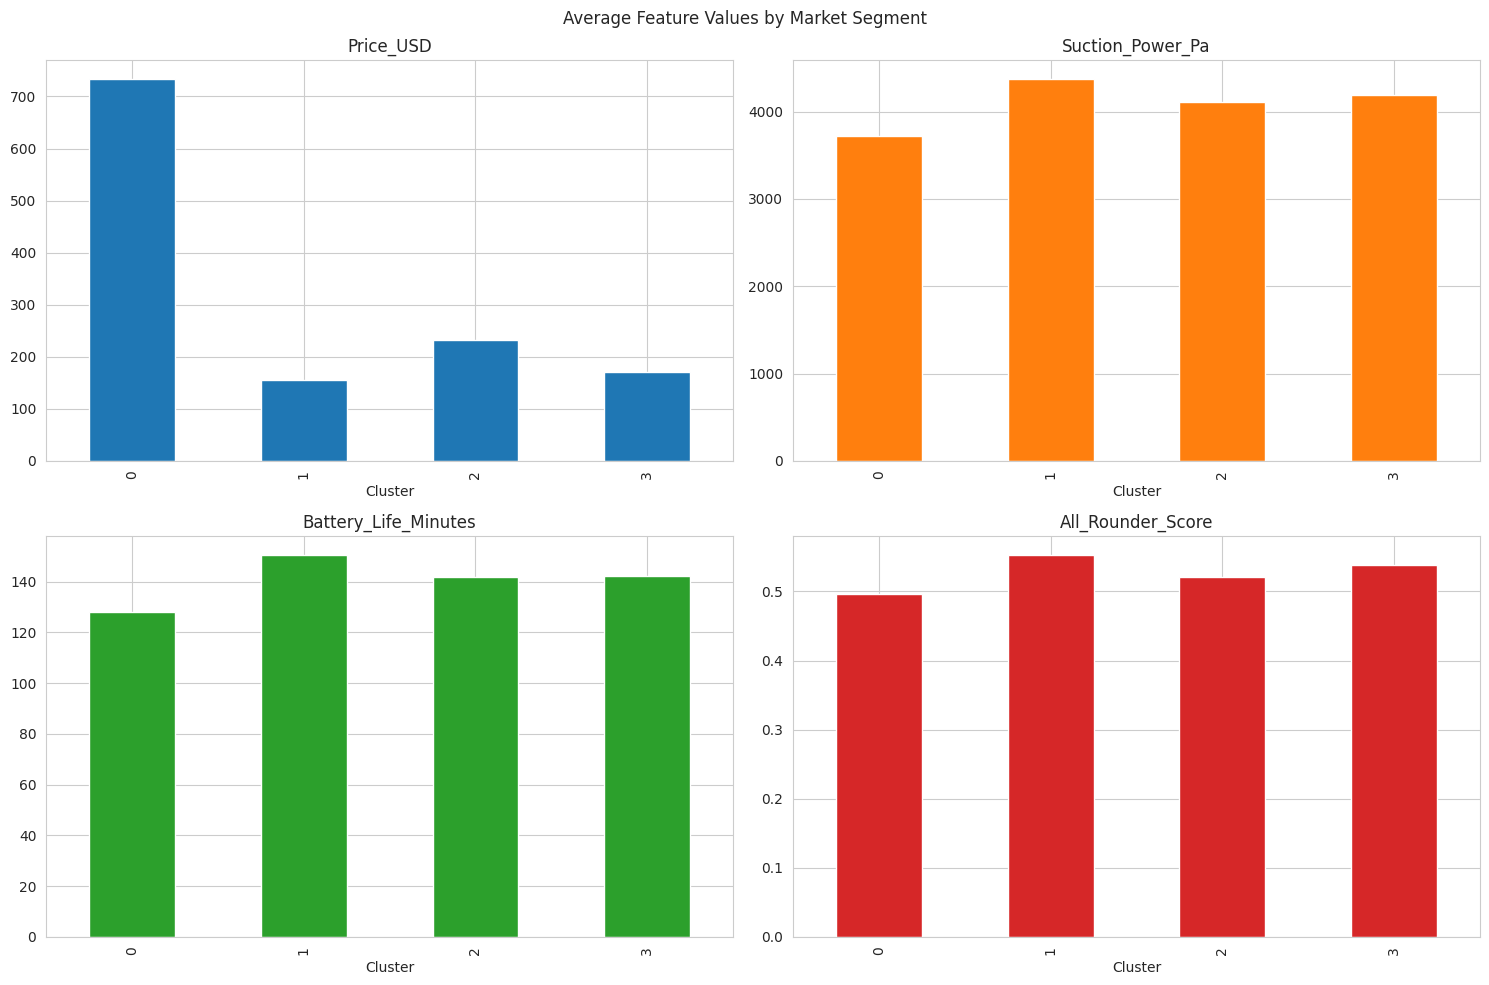

In [16]:
# Now that we have clusters, let's understand what defines them.
# We'll calculate the average of key features for each cluster.
cluster_characteristics = df.groupby('Cluster')[[
    'Price_USD',
    'Suction_Power_Pa',
    'Battery_Life_Minutes',
    'All_Rounder_Score'
]].mean().reset_index()

print("Average Characteristics by Cluster:")
display(cluster_characteristics)

# Visualize the characteristics using a bar plot
cluster_characteristics.plot(
    x='Cluster',
    kind='bar',
    subplots=True,
    figsize=(15, 10),
    layout=(2, 2),
    legend=False,
    sharex=False, # Each subplot has its own x-axis labels
    title='Average Feature Values by Market Segment'
)

plt.tight_layout()
plt.show()

## Creating the Interactive Dashboard

In [17]:
# Create the main figure object
fig = go.Figure()

# Create a bar chart for each profile
for profile in consumer_profiles.keys():
    score_col = f'{profile}_Score'
    df_sorted = df.sort_values(by=score_col, ascending=False).head(15)
    
    fig.add_trace(go.Bar(
        x=df_sorted['Brand'] + " " + df_sorted['Model'],
        y=df_sorted[score_col],
        name=profile,
        visible=(profile == "All_Rounder"), # Default view
        hovertemplate='<b>%{x}</b><br>Price: $%{customdata[0]:.2f}<br>Score: %{y:.3f}<extra></extra>',
        customdata=df_sorted[['Price_USD']]
    ))

# Create the dropdown menu buttons
buttons = [
    dict(
        label=profile.replace('_', ' '),
        method="update",
        args=[{"visible": [p == profile for p in consumer_profiles.keys()]},
              {"title": f"Top 15 Vacuums for the {profile.replace('_', ' ')} Profile"}]
    ) for profile in consumer_profiles.keys()
]

# Update the layout with the dropdown and titles
fig.update_layout(
    updatemenus=[dict(active=3, buttons=buttons, x=0.1, xanchor="left", y=1.15, yanchor="top")],
    title_text="Top 15 Vacuums for the All_Rounder Profile",
    xaxis_title="Robot Vacuum Model",
    yaxis_title="Calculated Value Score"
)

fig.show()

## Conclusion

This notebook successfully transformed a raw dataset into a powerful consumer decision-making tool. By engineering a "Vacuum Value Score," we were able to:

1.  **Rank Products for Personas:** Objectively score and rank vacuums based on specific, weighted needs.
2.  **Segment the Market:** Use clustering to identify distinct market segments, such as "Premium All-Rounders" or "Budget Specialists."
3.  **Provide Interactive Insights:** Create a dynamic dashboard that allows users to explore the data for themselves.

This approach demonstrates how data science can bridge the gap between complex data and practical, real-world applications.